# Dictionary Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
import sys

sys.path += ['..', '../..']
from modules.dictionary_learning.spd_dictionary_learning import AffineConstrainedSPDDLSC as DL
from modules.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d

## load an image

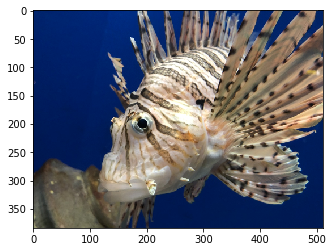

In [3]:
img_color = cv2.cvtColor(cv2.imread('../../data/fish.jpg'), cv2.COLOR_BGR2RGB)
ratio = 0.5
img_color = cv2.resize(img_color, None, fx=ratio, fy=ratio)
img = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

plt.imshow(img_color)

In [4]:
patch_size = (32, 32)
extraction_step = patch_size
n_components = 2
eps = 1e-16
patches = extract_patches_2d(img, patch_size, extraction_step).astype(np.float)

## Dictionary Learning

$$\mathop{\rm{minimize}}_{\mathcal{D}, W}\ \frac{1}{2}\sum_{i=1}^n\left\|\sum_{j=1}^mw_{ij}\log_{x_i}(a_j)\right\|_{x_i}^2 + \lambda\|W\|_1\quad
\text{subject to}\ a_j \in \mathcal{P}(r),\ \sum_{j=1}^m w_{ij} = 1$$

画像

In [5]:
%%time

kernel_x = np.array([[0,0,0],[-1,0,1],[0,0,0]])
kernel_y = np.array([[0,-1,0],[0,0,0],[0,1,0]])
kernel_xx = np.array([[0,0,0],[-1,2,-1],[0,0,0]])
kernel_yy = np.array([[0,-1,0],[0,2,0],[0,-1,0]])

dx = [np.abs(cv2.filter2D(p, cv2.CV_64F, kernel_x)) for p in patches]
dy = [np.abs(cv2.filter2D(p, cv2.CV_64F, kernel_y)) for p in patches]
ddx = [np.abs(cv2.filter2D(p, cv2.CV_64F, kernel_xx)) for p in patches]
ddy = [np.abs(cv2.filter2D(p, cv2.CV_64F, kernel_yy)) for p in patches]
feature_img = np.array(
    [np.cov(
        np.array(
            [p.flatten(), x.flatten(), y.flatten(), xx.flatten(), yy.flatten()]
        )
    ) + np.eye(5) * eps for p, x, y, xx, yy in zip(patches, dx, dy, ddx, ddy)]
)

CPU times: user 37.2 ms, sys: 4.59 ms, total: 41.8 ms
Wall time: 41.8 ms


## Sparse Coding

### Symmetrix Positive Definite Matrix

In [6]:
%%time
max_iter = 10
dl = DL(
    n_components = n_components ** 2,
    max_iter = max_iter,
    extended_output = True,
    initial_step = 1e-2,
    armijo_param = 1e-4,
    max_iter_dl = 5,
    rho = 1e-4,
    tau = len(patches),
    max_iter_sp = 100
)

transformed = dl.fit(feature_img)
%time transformed = dl.transform(feature_img)

100%|██████████| 10/10 [00:33<00:00,  3.40s/it]


CPU times: user 91.4 ms, sys: 13.8 ms, total: 105 ms
Wall time: 666 ms
CPU times: user 16.8 s, sys: 5.56 s, total: 22.4 s
Wall time: 34.6 s


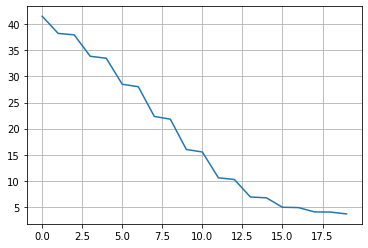

In [7]:
plt.plot(dl.f)
plt.grid(True)
plt.show()

## K-Means Result

### Symmetric Positive Definite Matrix

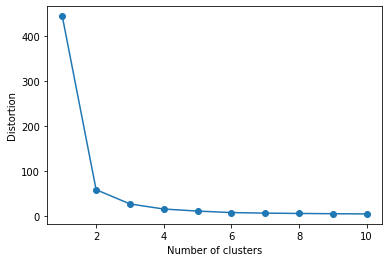

In [8]:
from sklearn.cluster import KMeans

# エルボー図
distortions = []

for i  in range(1,11):
    km = KMeans(
        n_clusters=i,
        init='k-means++',
        n_init=10,
        max_iter=300,
        random_state=0
    )
    km.fit(transformed)
    distortions.append(km.inertia_)

plt.plot(range(1,11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

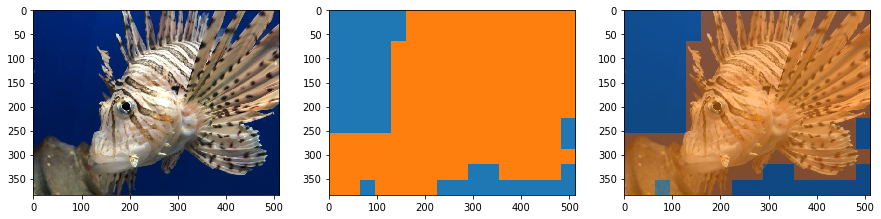

In [10]:
n_clusters = 2

kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(transformed)
labels = np.tile(plt.get_cmap('tab10')(kmeans.labels_)[:, :3], np.prod(patch_size)).reshape(-1, *patch_size, 3)
labels = np.uint8(reconstruct_from_patches_2d(labels, (*img.shape, 3), extraction_step) * 255)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(img_color)
plt.subplot(1,3,2)
plt.imshow(labels)
plt.subplot(1,3,3)
plt.imshow(cv2.addWeighted(img_color, 0.5, labels, 0.5, 0))
plt.show()